In [1]:
import os
os.listdir('./data')

['BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv']

In [2]:
import pandas as pd
df = pd.read_csv('./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [3]:
colname = ['0','Date','Price','3','4','5']
df = pd.read_csv('./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',names=colname,index_col='Date',parse_dates=['Date'],header=0)
df.head()

,0,Price,3,4,5
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
bitdf=df['Price']
bitdf.head()

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
2013-10-04    118.67466
2013-10-05    121.33866
Name: Price, dtype: float64

In [36]:
bitnp = bitdf.to_numpy()
bitnp

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [6]:
step = bitdf.index.to_numpy()
step

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', ...,
       '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
       '2021-05-18T00:00:00.000000000'], dtype='datetime64[ns]')

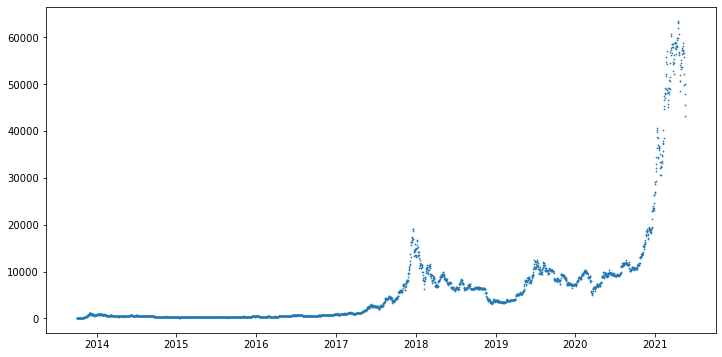

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(step,bitnp,s=0.5)

### create windows, horizons

In [35]:
import numpy as np
nwindows = 5
nhorizon = 1
w,h=7,1
def make_windows(x,w=7,h=1):
    #create 1d list of numbers of total size
    d1list = np.arange(w + h)
    print("d1list :", d1list)
    # create 2d of this list
    d2list = np.expand_dims(d1list,axis=0)
    print("d2list :", d2list)
    # create column of numbers to be added to the 2d list above
    addnum = np.expand_dims(np.arange(len(x)-(w+h-1)), axis=0).T
    print("addnum :", addnum)
    # final index is the array where each d2list is added with addnum
    window_indexes = d2list + addnum
    # get values of the input matrix for these indexes
    window_array = x[window_indexes]
    # create windows and lables from this
    windows = window_array[:, :-h]
    labels  = window_array[:,-h:]
    return windows, labels

# take the target data and split into windows and labels
windows, labels = make_windows(bitnp,nwindows,nhorizon)
windows, labels

d1list : [0 1 2 3 4 5]
d2list : [[0 1 2 3 4 5]]
addnum : [[   0]
 [   1]
 [   2]
 ...
 [2779]
 [2780]
 [2781]]


(array([[  123.65499   ,   125.455     ,   108.58483   ,   118.67466   ,
           121.33866   ],
        [  125.455     ,   108.58483   ,   118.67466   ,   121.33866   ,
           120.65533   ],
        [  108.58483   ,   118.67466   ,   121.33866   ,   120.65533   ,
           121.795     ],
        ...,
        [55715.54665129, 56573.5554719 , 52147.82118698, 49764.1320816 ,
         50032.69313676],
        [56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
         47885.62525472],
        [52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
         45604.61575361]]),
 array([[  120.65533   ],
        [  121.795     ],
        [  123.033     ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [37]:
windows[1],labels[1], len(windows), windows.shape, labels.shape

(array([125.455  , 108.58483, 118.67466, 121.33866, 120.65533]),
 array([121.795]),
 2782,
 (2782, 5),
 (2782, 1))

### Split into train, test sets

In [10]:
test_split = 0.2
split_size = int(len(windows)*(1-test_split))
trainw = windows[:split_size]
testw = windows[split_size:]
trainl = labels[:split_size]
testl = labels[split_size:]
len(trainw),len(trainl), len(testw),len(testl)

(2225, 2225, 557, 557)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
tf.random.set_seed(12)

model = tf.keras.Sequential([
    Dense(128,activation='relu'),
    Dense(nhorizon)
])

model.compile(loss = 'mae', optimizer = 'adam', metrics = 'mape')

filepath = './checkpoints/new/model'
callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_loss')

history = model.fit(trainw,trainl, epochs=50, batch_size = 32, callbacks = callback,
                   validation_data=(testw,testl))

Epoch 1/50
70/70 [==============================] - 1s 8ms/step - loss: 539.4556 - mape: 16.9978 - val_loss: 1082.0583 - val_mape: 4.8331
Epoch 2/50
70/70 [==============================] - 0s 5ms/step - loss: 162.7775 - mape: 4.3561 - val_loss: 850.9441 - val_mape: 3.7771
Epoch 3/50
70/70 [==============================] - 0s 1ms/step - loss: 159.4334 - mape: 4.3489 - val_loss: 1002.3520 - val_mape: 4.5241
Epoch 4/50
70/70 [==============================] - 0s 5ms/step - loss: 148.6503 - mape: 3.9879 - val_loss: 772.8650 - val_mape: 3.5105
Epoch 5/50
70/70 [==============================] - 0s 7ms/step - loss: 137.8477 - mape: 3.7030 - val_loss: 726.2530 - val_mape: 3.2225
Epoch 6/50
70/70 [==============================] - 0s 5ms/step - loss: 144.8904 - mape: 3.8934 - val_loss: 692.6624 - val_mape: 3.1185
Epoch 7/50
70/70 [==============================] - 0s 5ms/step - loss: 133.1477 - mape: 3.6784 - val_loss: 664.9243 - val_mape: 2.9768
Epoch 8/50
70/70 [===========================

70/70 [==============================] - 0s 1ms/step - loss: 107.7322 - mape: 3.0187 - val_loss: 567.9642 - val_mape: 2.5275
Epoch 49/50
70/70 [==============================] - 0s 2ms/step - loss: 109.9503 - mape: 3.0258 - val_loss: 647.6994 - val_mape: 3.0055
Epoch 50/50
70/70 [==============================] - 0s 2ms/step - loss: 115.3420 - mape: 3.1412 - val_loss: 565.0505 - val_mape: 2.5160


<AxesSubplot:>

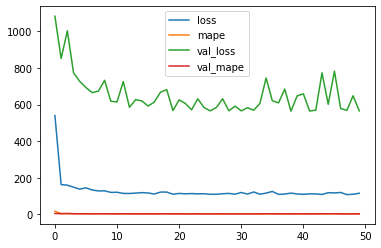

In [12]:
pd.DataFrame(history.history).plot()

In [13]:
model.evaluate(testw,testl)

18/18 [==============================] - 0s 1ms/step - loss: 565.0505 - mape: 2.5160


[565.0504760742188, 2.5160470008850098]

In [14]:
bestmodel = tf.keras.models.load_model(filepath)
bestmodel.evaluate(testw,testl)

18/18 [==============================] - 0s 1ms/step - loss: 563.7596 - mape: 2.5164


[563.7596435546875, 2.516418218612671]

# # Conv1D
#### input = (batch size, timesteps or window units, input dim or vector length)

In [17]:
trainw.shape, trainw[0].shape, trainw[0]

((2225, 5),
 (5,),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [19]:
# testing the dim expansion with a sample
x = tf.constant(trainw[0])
xexp = tf.expand_dims(x, axis=1)
x, xexp

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866])>,
 <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
 array([[123.65499],
        [125.455  ],
        [108.58483],
        [118.67466],
        [121.33866]])>)

In [28]:
# create model
from tensorflow.keras.layers import Lambda, Dense, Conv1D
model1d = tf.keras.Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=1)),
    Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    Dense(1)
])
model1d.compile(loss='mae', optimizer='adam', metrics='mae')
filepath='./checkpoints/model1d'
callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath)

model1d.fit(trainw,trainl,epochs=100,callbacks=callback,validation_data=(testw,testl))


Epoch 1/100
70/70 [==============================] - 1s 11ms/step - loss: 989.7226 - mae: 989.7226 - val_loss: 894.9015 - val_mae: 894.9015
Epoch 2/100
70/70 [==============================] - 1s 10ms/step - loss: 158.9046 - mae: 158.9046 - val_loss: 917.8801 - val_mae: 917.8801
Epoch 3/100
70/70 [==============================] - 1s 10ms/step - loss: 158.3650 - mae: 158.3650 - val_loss: 922.8393 - val_mae: 922.8393
Epoch 4/100
70/70 [==============================] - 1s 11ms/step - loss: 154.2815 - mae: 154.2815 - val_loss: 841.6771 - val_mae: 841.6771
Epoch 5/100
70/70 [==============================] - 1s 11ms/step - loss: 151.1189 - mae: 151.1189 - val_loss: 894.2678 - val_mae: 894.2678
Epoch 6/100
70/70 [==============================] - 1s 10ms/step - loss: 152.3929 - mae: 152.3929 - val_loss: 833.9059 - val_mae: 833.9059
Epoch 7/100
70/70 [==============================] - 1s 13ms/step - loss: 145.4930 - mae: 145.4930 - val_loss: 928.6750 - val_mae: 928.6750
Epoch 8/100
70/70 [=

Epoch 30/100
70/70 [==============================] - 1s 9ms/step - loss: 113.7861 - mae: 113.7861 - val_loss: 585.0046 - val_mae: 585.0046
Epoch 31/100
70/70 [==============================] - 1s 9ms/step - loss: 111.9854 - mae: 111.9854 - val_loss: 575.3853 - val_mae: 575.3853
Epoch 32/100
70/70 [==============================] - 1s 12ms/step - loss: 110.4998 - mae: 110.4998 - val_loss: 575.0331 - val_mae: 575.0331
Epoch 33/100
70/70 [==============================] - 1s 8ms/step - loss: 117.3896 - mae: 117.3896 - val_loss: 666.5674 - val_mae: 666.5674
Epoch 34/100
70/70 [==============================] - 1s 11ms/step - loss: 112.2757 - mae: 112.2757 - val_loss: 573.6786 - val_mae: 573.6786
Epoch 35/100
70/70 [==============================] - 1s 10ms/step - loss: 116.8439 - mae: 116.8439 - val_loss: 714.7289 - val_mae: 714.7289
Epoch 36/100
70/70 [==============================] - 1s 10ms/step - loss: 114.9505 - mae: 114.9505 - val_loss: 582.9304 - val_mae: 582.9304
Epoch 37/100
70/

Epoch 59/100
70/70 [==============================] - 1s 9ms/step - loss: 111.3025 - mae: 111.3025 - val_loss: 585.5584 - val_mae: 585.5584
Epoch 60/100
70/70 [==============================] - 1s 11ms/step - loss: 107.0102 - mae: 107.0102 - val_loss: 583.2849 - val_mae: 583.2849
Epoch 61/100
70/70 [==============================] - 1s 9ms/step - loss: 108.6216 - mae: 108.6216 - val_loss: 567.5464 - val_mae: 567.5464
Epoch 62/100
70/70 [==============================] - 1s 10ms/step - loss: 113.6616 - mae: 113.6616 - val_loss: 573.4152 - val_mae: 573.4152
Epoch 63/100
70/70 [==============================] - 1s 10ms/step - loss: 109.0545 - mae: 109.0545 - val_loss: 571.9103 - val_mae: 571.9103
Epoch 64/100
70/70 [==============================] - 1s 11ms/step - loss: 109.6328 - mae: 109.6328 - val_loss: 564.9832 - val_mae: 564.9832
Epoch 65/100
70/70 [==============================] - 1s 11ms/step - loss: 111.0730 - mae: 111.0730 - val_loss: 563.8281 - val_mae: 563.8281
Epoch 66/100
70

Epoch 88/100
70/70 [==============================] - 1s 10ms/step - loss: 111.8402 - mae: 111.8402 - val_loss: 615.1401 - val_mae: 615.1401
Epoch 89/100
70/70 [==============================] - 1s 10ms/step - loss: 110.6444 - mae: 110.6444 - val_loss: 564.7997 - val_mae: 564.7997
Epoch 90/100
70/70 [==============================] - 1s 10ms/step - loss: 107.6360 - mae: 107.6360 - val_loss: 571.3332 - val_mae: 571.3332
Epoch 91/100
70/70 [==============================] - 1s 10ms/step - loss: 111.6937 - mae: 111.6937 - val_loss: 571.8386 - val_mae: 571.8386
Epoch 92/100
70/70 [==============================] - 1s 10ms/step - loss: 111.4474 - mae: 111.4474 - val_loss: 565.4233 - val_mae: 565.4233
Epoch 93/100
70/70 [==============================] - 1s 14ms/step - loss: 112.4273 - mae: 112.4273 - val_loss: 570.9026 - val_mae: 570.9026
Epoch 94/100
70/70 [==============================] - 1s 10ms/step - loss: 108.1317 - mae: 108.1317 - val_loss: 640.6838 - val_mae: 640.6838
Epoch 95/100


In [29]:
model1d.evaluate(testw,testl)

18/18 [==============================] - 0s 959us/step - loss: 613.4019 - mae: 613.4019


[613.4019165039062, 613.4019165039062]

In [30]:
bestmodel1d=tf.keras.models.load_model(filepath)
bestmodel1d.evaluate(testw,testl)

18/18 [==============================] - 0s 941us/step - loss: 613.4019 - mae: 613.4019


[613.4019165039062, 613.4019165039062]